In [1]:
import numpy as np
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

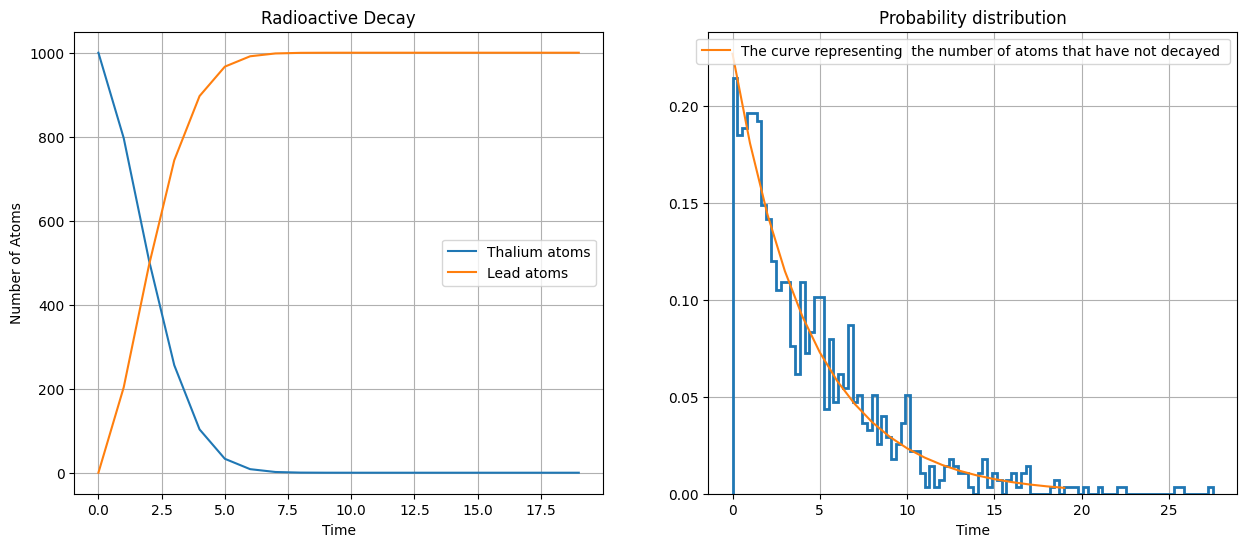

In [2]:
tau = 3.052
sample_Tl = 1000
sample_Pb = 0
U = np.random.random(1000)
time_vector = np.arange(20)
evo_Tl = np.zeros(np.size(time_vector))
evo_Pb = np.zeros(np.size(time_vector))


def prob(t,tau):
    temp = (-t/tau)
    return 1-pow(2,temp)

def prob_temp(x,tau):
    temp_1 = -tau*np.log(-x+1)
    temp_2 = np.log(2)
    return temp_1/temp_2

def prob_inverse(t,tau):
    temp_1 = (-t/tau)
    temp_2 = np.log(2)/tau
    return pow(2,temp_1)*temp_2

for i in time_vector:
    evo_Pb[i] = sample_Pb
    evo_Tl[i] = sample_Tl
    temp_sample = prob(i+1,tau)*sample_Tl 
    sample_Tl=sample_Tl-temp_sample
    sample_Pb = sample_Pb+temp_sample

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(time_vector,evo_Tl,label = "Thalium atoms")
plt.plot(time_vector,evo_Pb, label = "Lead atoms")
plt.title('Radioactive Decay')
plt.xlabel('Time')
plt.ylabel('Number of Atoms')
plt.legend()
plt.grid(True)


plt.subplot(122)
u = np.random.random(1000)
v = prob_temp(u,tau) # apply the inverse of the CDF
plt.hist(v, histtype='step', bins=100, density=True, linewidth=2)  # plot histogram of the sample v
plt.plot(time_vector,prob_inverse(time_vector,tau),label = "The curve representing  the number of atoms that have not decayed ")
plt.title('Probability distribution')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()


2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

Monte Carlo : 1.35
Mean value method: 1.3580331955848386
Monte Carlo with error estimation: 1.374 +- 0.030
Mean value method with error estimation: 1.353 +- 0.021


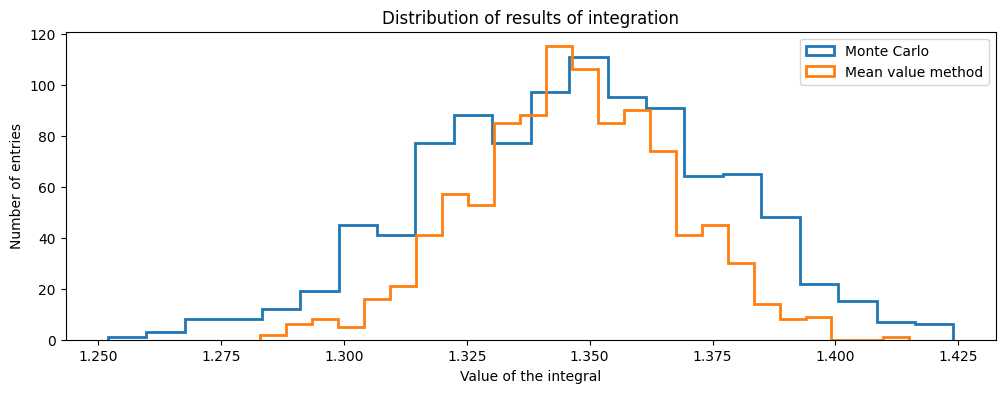

In [3]:
def f(x):
    temp = np.sin(1/(1-x))
    return pow(temp,2)

x = np.linspace(0,2,10000)


def Monte(a,b,ay,by,N):
    count = 0
    a, b = 0, 2 # a<->b is a range  of x
    ay, by = 0, 1
    for i in range(N):
        x = (b - a) * np.random.random() # x is random uniform between 0 and 2
        y = (by - ay) * np.random.random()     # y is random uniform between 0 and 1
        if y < f(x): count += 1
    return count / N * (b - a) * (by - ay)

def mean_value(x_min, x_max, n):
    xi = np.random.uniform(x_min, x_max, n)
    yi = np.array([f(xii) for xii in xi])
    s = np.sum(yi)
    return (x_max - x_min) / n * s

N = 1000
a, b = 0, 2 
ay, by = 0, 1

print("Monte Carlo :", Monte(a,b,ay,by,N))
print("Mean value method:", mean_value(a, b, N))

# Error estimation 
M = 1000

def calc_sigma(a,b,ay,by,N, M):
    In_monte = np.array([Monte(a,b,ay,by,N) for mi in np.arange(M)])
    sigma_monte = np.sqrt(np.mean(In_monte**2) - np.mean(In_monte)**2)
    In_mean = np.array([mean_value(a, b, N) for mj in np.arange(M)])
    sigma_mean = np.sqrt(np.mean(In_mean**2) - np.mean(In_mean)**2)
    return [sigma_monte, sigma_mean]

def calc_sigma_temp(a,b,ay,by,N, M):
    In_monte = np.array([Monte(a,b,ay,by,N) for mi in np.arange(M)])
    In_mean = np.array([mean_value(a, b, N) for mj in np.arange(M)])
    return [In_monte,In_mean]

sigma = calc_sigma(a, b,ay,by, N, M)
Integral = calc_sigma_temp(a,b,ay,by,N, M)
print("Monte Carlo with error estimation: %.3f +- %.3f" % (Monte(a,b,ay,by,N), sigma[0]))
print("Mean value method with error estimation: %.3f +- %.3f" % (mean_value(a, b, N), sigma[1]))

plt.figure(figsize=(12,4))
plt.xlabel("Value of the integral")
plt.ylabel("Number of entries")
plt.title("Distribution of results of integration")
plt.hist(Integral[0],histtype='step',bins="auto",label="Monte Carlo",linewidth = 2)
plt.hist(Integral[1],histtype='step',bins="auto",label="Mean value method",linewidth = 2)
plt.legend()
plt.show()

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [4]:
def circle(n):
    points = np.random.uniform(low=-1, high=1, size=(n, 2))
    hit = np.sum(np.linalg.norm(points, axis=1) <= 1)
    circle_temp = hit / n * 4
    return circle_temp

def volume(n, dim):
    points = np.random.uniform(low=-1, high=1, size=(n, dim))
    hit = np.sum(np.linalg.norm(points, axis=1) <= 1)
    volume_temp= hit / n * 2**dim
    return volume_temp

circle_1d = circle(100000)
volume_10d = volume(100000, 10)

print("Estimated area of the circle:", circle_1d)
print("Estimated volume of the 10D sphere:", volume_10d)


Estimated area of the circle: 3.14212
Estimated volume of the 10D sphere: 2.38592


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [5]:
def weigh(x):
    return 1/np.sqrt(x)

def f(x):
    return(pow(x,-0.5)/(np.exp(x)+1))

S = 1000000

def MwIS(N):
    Integral = 0
    for i in range(N):
        x = (np.random.random())**2
        Integral += (f(x)/weigh(x))
    return 2* Integral/N

print("Value of the integral is:", MwIS(S))



Value of the integral is: 0.8387621361685275
